In this section of the tutorial we will demonstrate how we can use graph neural networks in recommender systems.

**Prerequisites:**

- Familiarity with Jax, especially flax & jraph
- A grasp on the basics of neural networks
- A foundation in graph theory (Recommended: MIT Open Courseware [slides](https://ocw.mit.edu/courses/1-022-introduction-to-network-models-fall-2018/resources/mit1_022f18_lec2/) by Amir Ajorlou)
- A recap from last year's tutorial on graph neural networks: [DLI GNN TUTORIAL](https://colab.research.google.com/github/deep-learning-indaba/indaba-pracs-2022/blob/main/practicals/GNN_practical.ipynb#scrollTo=51TEXn_OI4Ee)

**Aims/Learning Objectives:**
- The basic foundations of graphs and GNNs. This section is taken from last year's tutotial. Feel free to go through that tutorial for more in depth on graphs.
- Frame link prediction tasks within the context of movie recommendations
- Implementation of GCN for movie recommendations
- Inference on test dataset

# Introduction

Graphs are a powerful and general representation of data with a wide range of applications. Most people are familiar with their use in contexts like social networks and biological systems. Another use case for graphs is in the realm of recommender systems. In Section 2, we'll delve into the specifics of how we can frame recommendations as tasks within the context of graph neural networks.

# Section 1: Graphs

## 1.1. Recap of graph fundamentals

A **graph** is a pair $\mathscr{G} = (\mathscr{V}, \mathscr{E})$, where $\mathscr{V}$ is the set of $N$ **vertices** (nodes), and $\mathscr{E}$ is the set of graph **edges** (links), i.e., pairs $(u,v)$ representing a connection between two vertices $u,v \in \mathscr{V}$. An **undirected** graph is one in which $(u,v) \in \mathscr{E} \implies (v,u) \in \mathscr{E}$.

There are several ways to represent $\mathscr{E}$:
1. As a **list of edges**: a list of pairs $(u,v)$, where $(u,v)$ means that there is an edge going from node $u$ to node $v$.
2. As an **adjacency matrix**: a binary square matrix $A$ of size $|\mathscr{V}| \times |\mathscr{V}|$, where $A_{u,v}=1$ iff there is a connection between nodes $u$ and $v$.
3. As an **adjacency list**: An array of $|\mathscr{V}|$ unordered lists, where the $i$th list corresponds to the $i$th node, and contains all the nodes directly connected to node $i$.


Example: Below is a directed graph with four nodes and five edges.

<image src="https://storage.googleapis.com/dm-educational/assets/graph-nets/toy_graph.png" width="400px">

The arrows on the edges indicate the direction of each edge, e.g. there is an edge going from node 0 to node 1. Between node 0 and node 3, there are two edges: one going from node 0 to node 3 and one from node 3 to node 0.

Node 0 has out-degree of 2, since it has two outgoing edges, and an in-degree of 2, since it has two incoming edges.

The list of edges is:
$$[(0, 1), (0, 3), (1, 2), (2, 0), (3, 0)]$$

As adjacency matrix:

$$\begin{array}{l|llll}
 source \setminus dest    & n_0 & n_1 & n_2 & n_3 \\ \hline
n_0 & 0    & 1    & 0    & 1    \\
n_1 & 0    & 0    & 1    & 0    \\
n_2 & 1    & 0    & 0    & 0    \\
n_3 & 1    & 0    & 0    & 0
\end{array}$$

As adjacency list:

$$[\{1, 3\}, \{2\}, \{0\}, \{0\}]$$



# Section 1.2: Graph Neural Network Theory

A GNN is a neural network designed to work on graph data. We start with an initial representation of our problem in the form of a graph. In the figure below, you can see an example of such a graph. The diagram illustrates new important aspects of graph neural networks:
- Each node has an initial vector representation (grey box associated with each node)
- Node are connected by different edge types (represented by different coloured arrows).

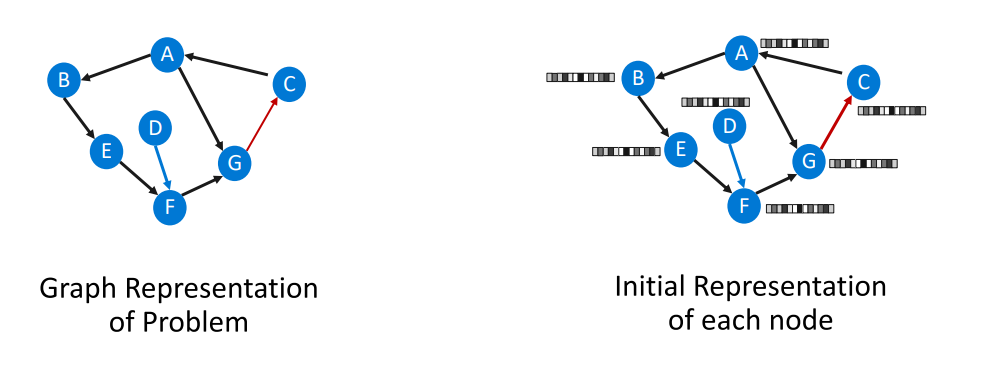

*Image Source: [An Introduction to Graph Neural Networks: Models and Application ](https://www.youtube.com/watch?v=zCEYiCxrL_0&t=824s)*

The GNN updates these node representations during training, outputting task-specific output representations. An overview of this process is illustrated below:

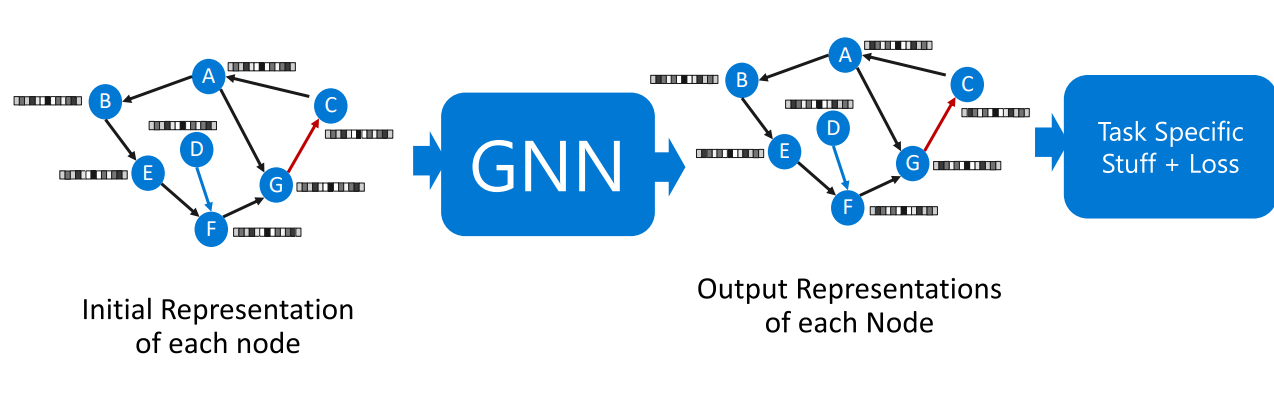


*Image Source: [An Introduction to Graph Neural Networks: Models and Application ](https://www.youtube.com/watch?v=zCEYiCxrL_0&t=824s)*

Neural Message Passing is a popular framework to perform this update. In a nutshell, each node representation is updated by exchanging information with the neighbouring nodes. To examine the node update in detail, let's consider a smaller neighbourhood of the graph such as nodes D, E and F pictured below.

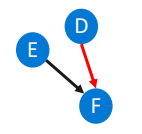

To update the vector representation of node F, we consider the following:

- Current vector representation of node F
- Vector representations of all nodes connected to F (e.g. E and D).
- Edge types of connected nodes.  

For each neighbour node (e.g. E and F) we compute a 'message' using some function $f$, which takes in the adjacent node representation and edge type as input. The output of function $f$ is the message vector. There are a vareity of different functions we could use to prepare this message and we'll go into some concrete examples later in the tutorial.

The messages from all the adjacent nodes are then summarized and used to update the current node state. The diagram below illustrates this process, whereby the vector representation of node F at time $t$ is labelled as $h^{n}_{t-1}$.

The notation is as follows:
- $t$ = timestep
- $h$ = node vector representation
- $k$ = edge type
- $f$ = function which prepares a message
- $⋃$ = function which summarised the messages
- $q$ = node update function

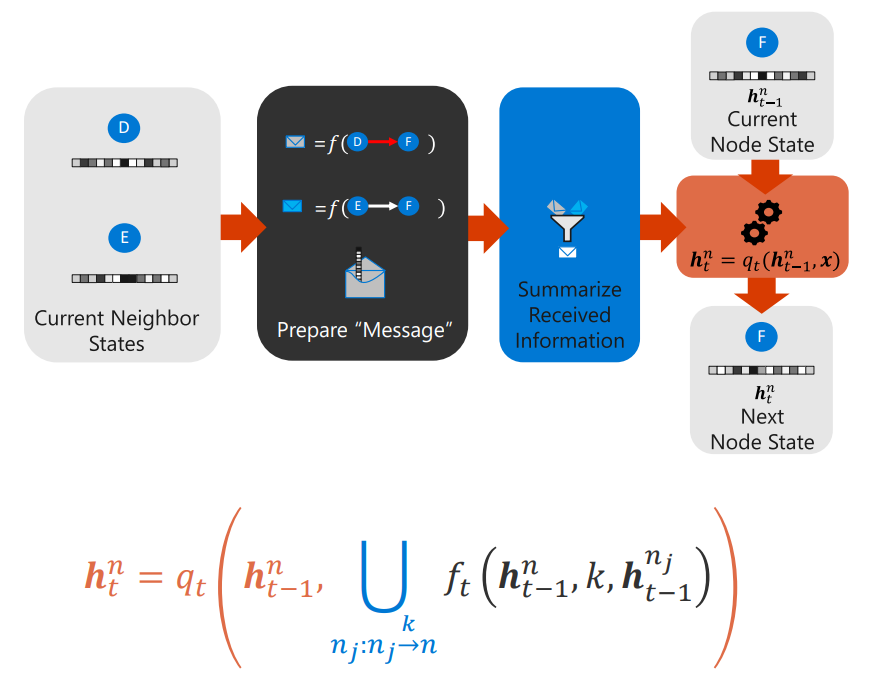

*Image Source: [An Introduction to Graph Neural Networks: Models and Application ](https://www.youtube.com/watch?v=zCEYiCxrL_0&t=824s)*

The equation at the bottom of the image is coloured coded to match the step in the diagram. For example, black represents the function to prepare the message, blue the function to summarise these messages and orange to update the node step.

Note that $⋃$ must be permutation invariant, as the messages are not ordered.

## Graph Prediction Tasks
What are the kinds of problems we want to solve on graphs?


The tasks fall into roughly three categories:

1. **Node Classification**: E.g. what is the topic of a paper given a citation network of papers?
2. **Link Prediction / Edge Classification**: E.g. are two people in a social network friends?
3. **Graph Classification**: E.g. is this protein molecule (represented as a graph) likely going to be effective?

<image src="https://storage.googleapis.com/dm-educational/assets/graph-nets/graph_tasks.png" width="700px">

*The three main graph learning tasks. Image source: Petar Veličković.*

Which examples of graph prediction tasks come to your mind? Which task types do they correspond to?


# Section 2: Using GNNs in Recommender systems

 A recommender system can be visualized as a graph, where entities (such as users and items) are nodes, and the interactions between them (such as ratings or purchase history) are edges. In the context of a movie recommendation system:

- Nodes represent:
    - Users: Individuals consuming the content.
    - Movies: Content items to be recommended.
- Edges represent:
    - Ratings: A directed edge from a user to a movie, annotated with a weight that indicates the rating (e.g., on a scale of 1 to 5).



## Section 2.1: Link (or Edge) Prediction in Recommender Systems

One of the foundational tasks in graph-based recommender systems is link prediction. In essence, link prediction tries to predict whether a link (or edge) should exist between two nodes, even if it's currently absent. For our movie recommendation system, this translates to predicting whether a user would like (or dislike) a movie they haven't yet rated.

The process works as follows:
1. Train on Existing Edges: Use known ratings (edges) from users to movies to train a model.
2. Predict Missing Edges: For a given user, predict ratings for movies they haven't seen or rated. This is akin to predicting missing or potential edges in our graph.
3. Recommend Based on Predictions: Movies with the highest predicted ratings are recommended to the user.

In this section of the tutorial, we will leverage graph neural networks (GNNs) for this link prediction task. The GNNs operate on the graph, aggregating information from neighboring nodes to produce accurate predictions for unseen edges. The below figure showcases a user-item sub-knowledge graph. Each icon denotes an entity or concept, and the connecting lines or edges symbolize the relationships between them.

![Description](https://drive.google.com/uc?export=view&id=1OeP-Ufd1zK27IS7cNXug2TZ56NcqTX-B)

*Image source: [HI2Rec: Exploring Knowledge in Heterogeneous Information for Movie Recommendation](https://www.semanticscholar.org/paper/HI2Rec%3A-Exploring-Knowledge-in-Heterogeneous-for-He-Wang/038eb4e6839352c8fa8f9c4f5ae5ff958e14c5a3)*

In [1]:
# @title Instalations
%%capture
!pip install git+https://github.com/deepmind/jraph.git
!pip install torch-geometric
!pip install networkx

In [2]:
#@title Importing dependencies
import gc
import torch
import jax
import jraph
import optax
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from jraph import GraphConvolution
import jax.tree_util as tree
from typing import Tuple, Sequence, Callable
from flax import linen as nn
import jax.numpy as jnp
import tensorflow_datasets as tfds
from flax.training import train_state
from torch_geometric.data import Data
from torch_geometric.transforms import RandomLinkSplit

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

In [3]:
#@title Load movielens dataset function
def load_movielens_dataframes():
    """
    Load the movielens/100k-ratings and movielens/100k-movies datasets from TFDS.

    Returns:
        ratings_df (pd.DataFrame): DataFrame containing the user ratings data.
        movies_df (pd.DataFrame): DataFrame containing the movie details.

    Example:
        ratings_df, movies_df = load_movielens_dataframes()
    """

    # Load the data
    ratings = tfds.load('movielens/100k-ratings', split="train", download=True)
    movies = tfds.load('movielens/100k-movies', split="train", download=True)

    # Convert ratings data to DataFrame
    ratings_records = [{
        # 'movie_title': example['movie_title'].numpy().decode('utf-8'),
        'user_id': example['user_id'].numpy().decode('utf-8'),
        'movie_id': example['movie_id'].numpy().decode('utf-8'),
        'user_rating': example['user_rating'].numpy()
    } for example in ratings]
    ratings_df = pd.DataFrame(ratings_records)

    # Convert movies data to DataFrame (assuming a similar structure; modify field names as needed)
    movies_records = [{
        'movie_title': example['movie_title'].numpy().decode('utf-8'),
        'movie_id': example['movie_id'].numpy().decode('utf-8'),
        'movie_genres': list(example['movie_genres'].numpy()) # already encoded (e.g., 1 might correspond to "Action", 2 to "Comedy", and so forth)
    } for example in movies]
    movies_df = pd.DataFrame(movies_records)

    return ratings_df, movies_df

In [ ]:
# load movielens data as pandas dataframe
ratings_df, movies_df = load_movielens_dataframes()

In [5]:
movies_df.head()

,movie_title,movie_id,movie_genres
0,You So Crazy (1994),1681,[4]
1,Love Is All There Is (1996),1457,"[4, 7]"
2,Fly Away Home (1996),500,"[1, 3]"
3,In the Line of Duty 2 (1987),838,[0]
4,"Niagara, Niagara (1997)",1648,[7]


In [6]:
ratings_df.head()

,user_id,movie_id,user_rating
0,138,357,4.0
1,92,709,2.0
2,301,412,4.0
3,60,56,4.0
4,197,895,3.0


In [7]:
movies_df.shape, ratings_df.shape

((1682, 3), (100000, 3))

In [8]:
print('number of unique movies: ', len(ratings_df.movie_id.unique()))
print('number of unique users: ', len(ratings_df.user_id.unique()))

number of unique movies:  1682
number of unique users:  943


In [9]:
#@title Transform data into graph
class GraphDataPreparation:
    def __init__(
        self, ratings_df: pd.DataFrame, movies_df: pd.DataFrame, split = 0.2
    ):
        """
        Initialize the class with ratings and movies dataframes.

        Args:
            ratings_df: DataFrame with ratings data.
            movies_df: DataFrame with movies data.
        """
        self.ratings_df = ratings_df
        self.movies_df = movies_df

        # Create mappings for userId and movieId to new continuous indexes
        self.user_mapping = {
            user_id: i for i, user_id in enumerate(self.ratings_df.user_id.unique())
        }
        self.movie_mapping = {
            movie_id: i for i, movie_id in enumerate(self.ratings_df.movie_id.unique())
        }

        # Apply the mappings to set new continuous userIds and movieIds
        self.ratings_df["user_id"] = self.ratings_df["user_id"].map(self.user_mapping)
        self.ratings_df["movie_id"] = self.ratings_df["movie_id"].map(
            self.movie_mapping
        )
        self.movies_df["movie_id"] = self.movies_df["movie_id"].map(self.movie_mapping)
        # Initialize edge splitting transformation
        self.transform = RandomLinkSplit(is_undirected=False, num_val=split)

    def create_edge_index(self):
        """
        Create an edge index for the graph. Edge direction is from user to movie.

        Returns:
            A tensor representing the edge index.
        """
        user_nodes = self.ratings_df["user_id"].to_numpy()
        movie_nodes = (
            self.ratings_df["movie_id"].to_numpy()
            + self.ratings_df["user_id"].nunique()
        )

        edge_index = torch.tensor(np.array([user_nodes, movie_nodes]), dtype=torch.long)

        return edge_index

    def create_edge_features(self):
        """
        Create edge features for the graph.

        Returns:
            A tensor representing the edge features.
        """
        ratings = self.ratings_df["user_rating"].to_numpy()
        edge_attr = torch.tensor(ratings, dtype=torch.float).view(-1, 1)

        return edge_attr

    def create_node_features(self):
        """
        Create node features for the graph.

        Returns:
            A tensor representing the node features.
        """

        # Prepare movie features
        movie_genres = self.movies_df["movie_genres"].apply(lambda x: pd.Series(x))
        movie_features = (
            pd.get_dummies(movie_genres.stack()).groupby(level=0).sum().values
        )

        # Prepare user features
        num_users = self.ratings_df["user_id"].nunique()
        user_embeddings = torch.nn.Embedding(num_users, movie_features.shape[1])
        user_features = user_embeddings.weight.detach().numpy()

        # Combine user and movie features
        node_features = np.vstack([user_features, movie_features])
        node_features = torch.tensor(node_features, dtype=torch.float)

        return node_features

    def create_edge_mask(self, original_edge_index, edge_label_index):
        # Convert the edges to a set of tuples for easy lookup
        label_edges_set = set([tuple(x) for x in edge_label_index.t().numpy()])

        # Generate the mask by checking each edge in original_edge_index
        mask = [tuple(x) for x in original_edge_index.t().numpy()]
        mask = [edge in label_edges_set for edge in mask]

        return np.array(mask)[:, None]

    def convert_to_jraph(self, data):
        """ Convert the Pytorch Data Object """
        graph = jraph.GraphsTuple(
            nodes=np.array(data.x),
            edges=np.array(data.edge_attr),
            n_node=np.array([data.num_nodes]),
            n_edge=np.array([data.num_edges]),
            senders=np.array(data.edge_index[0]),  # users are source
            receivers=np.array(data.edge_index[1]),  # movies are recievers
            globals=np.array([])
        )
        return graph

    def prepare_data(self):
        """
        Prepare the graph data.

        Returns:
            A train and test PyG Data object with the prepared graph data.
        """
        edge_index = self.create_edge_index()
        edge_attr = self.create_edge_features()
        node_features = self.create_node_features()
        graph = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr)
        train_graph, val_graph, test_graph = self.transform(graph)

        train_mask = self.create_edge_mask(graph.edge_index, train_graph.edge_label_index)
        val_mask = self.create_edge_mask(graph.edge_index, val_graph.edge_label_index)
        test_mask = self.create_edge_mask(graph.edge_index, test_graph.edge_label_index)
        graph = self.convert_to_jraph(graph)
        return graph, train_mask, val_mask, test_mask


In [10]:
# Convert data into graph
graph = GraphDataPreparation(ratings_df = ratings_df, movies_df = movies_df, split=0.4)
graph, train_mask, val_mask, test_mask = graph.prepare_data()
graph.edges.shape

(100000, 1)

In [12]:
#@title Model
class MLP(nn.Module):
  """A flax MLP."""
  features: Sequence[int]
  kernel_init: Callable = jax.nn.initializers.he_uniform()
  bias_init: Callable = jax.nn.initializers.zeros

  @nn.compact
  def __call__(self, inputs):
    x = inputs
    for i, feat in enumerate(self.features):
        lyr = nn.Dense(feat, kernel_init=self.kernel_init, bias_init=self.bias_init, name=f"mlp_dense_{i}")
        x = lyr(x)
        x = nn.relu(x)
    return x

def make_embed_fn(latent_size):
    def embed(inputs):
        return nn.Dense(latent_size)(inputs)
    return embed

class GraphConvLayer(nn.Module):

  output_decoder_dim: int
  latent_size: int
  update_node_fn: Callable
  aggregate_nodes_fn: Callable = jax.ops.segment_sum
  add_self_edges: bool = False
  symmetric_normalization: bool = True
  layer_norm: bool = False

  @nn.compact
  def __call__(self, graph):
    embedder = jraph.GraphMapFeatures(
        embed_node_fn=make_embed_fn(self.latent_size),
    )
    gcn = GraphConvolution(
        update_node_fn=self.update_node_fn,
        aggregate_nodes_fn=self.aggregate_nodes_fn,
        add_self_edges=self.add_self_edges,
        symmetric_normalization=self.symmetric_normalization
    )
    # Embed the graph nodes and edges
    graph = embedder(graph)
    graph = gcn(graph)
    if self.layer_norm:
      # Apply layer normalization to the node embeddings
      normalized_nodes = nn.LayerNorm()(graph.nodes)
      # Update the graph with the normalized node embeddings
      graph = graph._replace(nodes=normalized_nodes)

    edge_predictions = jnp.sum(graph.nodes[graph.senders] * graph.nodes[graph.receivers], axis=-1)
    edge_predictions = jnp.expand_dims(edge_predictions, axis=1)
    edge_predictions = nn.Dense(self.output_decoder_dim, name="mlp_dense_output")(edge_predictions)

    # Apply sigmoid activation and scale by 5
    edge_predictions = jax.nn.sigmoid(edge_predictions) * 5
    return edge_predictions


In [13]:
# Define one layer gcn
gcn_layer = GraphConvLayer(
    output_decoder_dim = 1,
    latent_size = 64,
    update_node_fn=lambda n: MLP(features=[64, 64])(n),
    aggregate_nodes_fn=jax.ops.segment_sum,
    add_self_edges=False,
    symmetric_normalization=True
)

# Initialize to see the output shapes
params = gcn_layer.init(jax.random.PRNGKey(42), graph)
output = gcn_layer.apply(params, graph)
output.shape, graph.edges.shape

((100000, 1), (100000, 1))

In [14]:
# Define loss function
def l1_loss(logits: np.ndarray, y: np.ndarray, mask: np.array, reduction: str = "mean") -> np.ndarray:
    """Implementation of l1_loss.

    Args:
        logits: model output logits.
        y: class labels.
        reduction: if reduction is mean, the average is returned, else if it is sum, the sum is returned.

    Returns:
       l1 loss.
    """
    logits_masked = logits * mask.astype(int)
    preds_masked = y * mask.astype(int)
    if reduction == "mean":
        loss = jnp.mean(jnp.abs(logits_masked - preds_masked))
    if reduction == "sum":
        loss = jnp.sum(jnp.abs(logits_masked - preds_masked))

    return loss

l1_loss(output, graph.edges, mask=val_mask)

Array(0.53192997, dtype=float32)

In [15]:
#@title Define flax train state
def create_train_state(
    model, graph, tx, rngs
):
    """Train state. This function initializes the model."""

    @jax.jit
    def initialize(params_rng):
        variables = model.init(
            params_rng,
            graph,
        )
        return variables

    variables = initialize(rngs)
    state = train_state.TrainState.create(apply_fn=model.apply, params=variables["params"], tx=tx)

    param_count = sum(x.size for x in jax.tree_util.tree_leaves(state.params))
    print("---> number of model parameters: ", param_count)
    return state

In [16]:
# Initialize model, train state, and other hparams
optimizer = optax.adam(learning_rate=0.001)
rng = jax.random.PRNGKey(0)
rng, init_rng = jax.random.split(rng)
rngs = {"params": rng, "dropout": init_rng}

model = GraphConvLayer(
    output_decoder_dim = 1,
    latent_size = 128,
    update_node_fn=lambda n: MLP(features=[128, 128, 64])(n),
    aggregate_nodes_fn=jax.ops.segment_sum,
    add_self_edges=True,
    layer_norm=True,
    symmetric_normalization=True
)
state = create_train_state(
    model=model,
    graph=graph,
    tx=optimizer,
    rngs=rngs,
)

---> number of model parameters:  43970


In [17]:
@jax.jit
def train_step(
    state: train_state.TrainState,
    graph: jnp.array,
    labels: jnp.ndarray,
    mask: jnp.ndarray,
    rngs: dict,
) -> Tuple[train_state.TrainState, tuple]:
    """Performs one update step over the graph.

    Args:
        state: training state.
        graph: graph node features.
        labels: graph edge labels.
        mask: mask for labels to consider for optimization
        rngs: rngs for droupout

    Returns:
        Current training state, the loss, and logits.
    """
    step = state.step
    rngs = {name: jax.random.fold_in(rng, step) for name, rng in rngs.items()}

    def loss_fn(params, graph, labels):
        # Compute logits and resulting loss.
        variables = {"params": params}
        logits = state.apply_fn(
            variables,
            graph=graph,
            rngs=rngs,
        )
        loss = l1_loss(logits=logits, y=labels, mask=mask)
        return loss, logits

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(state.params, graph, labels)
    new_state = state.apply_gradients(grads=grads)
    return new_state, (loss, logits)


In [18]:
@jax.jit
def evaluate_step(
    state: train_state.TrainState,
    graph: jnp.array,
    labels: jnp.ndarray,
    mask: jnp.ndarray,
    dropout_rng: dict = None,
) -> tuple:
    """Performs evaluation step over a set of inputs."""
    variables = {"params": state.params}
    logits = state.apply_fn(
        variables,
        graph=graph,
        rngs=dropout_rng,
    )
    loss = l1_loss(logits=logits, y=labels, mask=mask)
    return (loss, logits)

In [19]:

def train_eval(state, graph, train_mask, val_mask, rng, epochs = 10):
    final_train_loss = []
    final_val_loss = []
    for epoch in range(epochs):
        rng, epoch_rng = jax.random.split(rng)
        epoch_rng = {"dropout": epoch_rng}

        state, (train_loss, train_logits) = train_step(state=state, graph=graph, labels=graph.edges, mask=train_mask, rngs = epoch_rng)

        val_loss, val_logits = evaluate_step(state=state, graph=graph, mask=val_mask, labels=graph.edges)
        print(f"Epoch: {epoch}, train_loss: {train_loss}, val_loss: {val_loss}")
        final_train_loss.append(train_loss.item())
        final_val_loss.append(val_loss.item())

    return (state, final_train_loss, final_val_loss)

In [20]:
epochs = 40
final_state, final_train_loss, final_val_loss = train_eval(state=state, graph=graph, train_mask=train_mask, val_mask=val_mask, rng=rng, epochs = epochs)

Epoch: 0, train_loss: 1.4100292921066284, val_loss: 1.4118924140930176
Epoch: 1, train_loss: 1.4095996618270874, val_loss: 1.41162109375
Epoch: 2, train_loss: 1.4093478918075562, val_loss: 1.410475492477417
Epoch: 3, train_loss: 1.4082752466201782, val_loss: 1.4062105417251587
Epoch: 4, train_loss: 1.404070258140564, val_loss: 1.3981289863586426
Epoch: 5, train_loss: 1.3966152667999268, val_loss: 1.385992169380188
Epoch: 6, train_loss: 1.3856487274169922, val_loss: 1.3581771850585938
Epoch: 7, train_loss: 1.3592493534088135, val_loss: 1.3296416997909546
Epoch: 8, train_loss: 1.3293691873550415, val_loss: 1.2856277227401733
Epoch: 9, train_loss: 1.2862703800201416, val_loss: 1.2442653179168701
Epoch: 10, train_loss: 1.244411587715149, val_loss: 1.1982742547988892
Epoch: 11, train_loss: 1.2009111642837524, val_loss: 1.1630160808563232
Epoch: 12, train_loss: 1.1662604808807373, val_loss: 1.1357285976409912
Epoch: 13, train_loss: 1.1376538276672363, val_loss: 1.1039701700210571
Epoch: 14, 

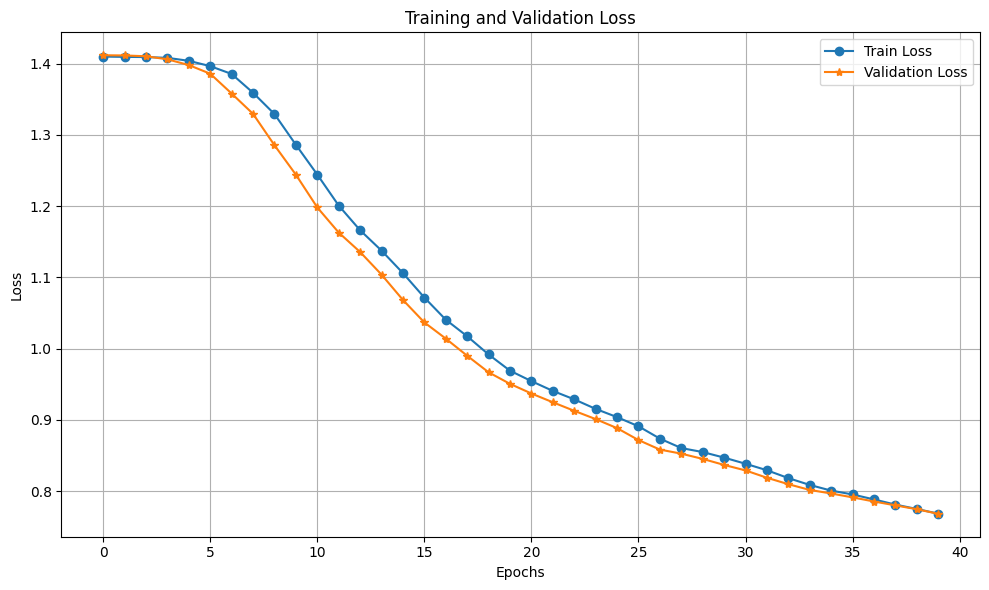

In [21]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), final_train_loss, label="Train Loss", marker='o')
plt.plot(range(epochs), final_val_loss, label="Validation Loss", marker='*')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Inference on test graph

In this section, we will show how we can recommend top N movies for a specific user based on the trained GNN. Since we already have a test set edges. We will use this to demonstrate the inference. We will do the following:

1. Extract Test Edges: With the test_mask, obtain the edges that belong to the test set.
2. Predict Ratings: For each of these test edges, use the trained GNN to predict a rating.
3. Map to Original Data: Using the movie_mapping and user_mapping from the GraphDataPreparation class, convert the predicted edges back to the original movie and user IDs.
4. Get Movie Names: For the mapped movie IDs, fetch the actual movie names.
5. To get the top N recommended movies for a particular user, we will sort the movies based on the predicted ratings and then pick the top N movies from the sorted list.

Below we will implement two functions to do the above steps